In [1]:
# imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import sys
import tensorflow as tf
import pickle
from sklearn.decomposition import PCA
from scipy.stats.stats import pearsonr
import argparse
import keras
from keras.models import Sequential, Model, model_from_json
from keras.layers import Input, Embedding, LSTM, Dense
from keras.layers.core import Reshape, Flatten, Dropout
from keras import metrics, optimizers
import re
import datetime
from sklearn.manifold import TSNE
import random

Using TensorFlow backend.


In [12]:
# load the dataframes
data_dir = 'data'
bacteria_df = pd.read_pickle(os.path.join(data_dir, 'BacterialSpecies.df'))
glucose_df = pd.read_pickle(os.path.join(data_dir, 'GlucoseValues.df'))
xy_df = pd.read_pickle(os.path.join(data_dir, 'x_y.df'))
blood_df = pd.read_pickle(os.path.join(data_dir, 'BloodTests.df'))
meals_df = pd.read_pickle(os.path.join(data_dir, 'Meals.df'))
sleeps_df = pd.read_pickle(os.path.join(data_dir, 'Sleep.df'))
exercises_df = pd.read_pickle(os.path.join(data_dir, 'Exercises.df'))
measurements_df = pd.read_pickle(os.path.join(data_dir, 'Measurements.df'))
testfoods_df = pd.read_pickle(os.path.join(data_dir, 'TestFoodsNew.df'))
# x_features_df = pd.read_pickle('/home/noamba/dnnChallenge/src/x_df_with_features.pickle')
xy_raw_df = pd.read_pickle('/home/noamba/dnnChallenge/src/data/x_y_raw.df')
# x_raw_features = pd.read_pickle('/home/noamba/dnnChallenge/x_with_features_raw_including_meals_sleep_exercise_5min.pickle')
# x_raw_features_meals = pd.read_pickle('/home/noamba/dnnChallenge/x_with_features_raw_including_meals.pickle')

In [59]:
# from sklearn import datasets, linear_model

# # Load the diabetes dataset
# diabetes = datasets.load_diabetes()


# # Use only one feature
# diabetes_X = diabetes.data[:, np.newaxis, 2]

# # Split the data into training/testing sets
# diabetes_X_train = diabetes_X[:-20]
# diabetes_X_test = diabetes_X[-20:]

# # Split the targets into training/testing sets
# diabetes_y_train = diabetes.target[:-20]
# diabetes_y_test = diabetes.target[-20:]

# # Create linear regression object
# regr = linear_model.LinearRegression()

# # Train the model using the training sets
# regr.fit(diabetes_X_train, diabetes_y_train)

# e = [[1,2,1],[2,2,1],[3,2,1],[4,3,1],[1,1,1]]

# x = np.array(e)
# y = np.array([5,6,7,10,3])

# regr = linear_model.LinearRegression()
# regr.fit(x, y)

# regr.coef_

MODELS_TO_USE = ['/home/noamba/dnnChallenge/src/trained_model_2d_16e_5min.h5',
                 '/home/noamba/dnnChallenge/src/trained_model_2d_15e_5min_6k_0.9tp_0.001lr_.h5',
                 '/home/noamba/dnnChallenge/src/trained_model_1d_20e_5min_5k_0.9tp_0.001lr_.h5',
                 '/home/noamba/dnnChallenge/src/trained_model_1d_20e_5min_7k_0.9tp_0.001lr_.h5',
                 '/home/noamba/dnnChallenge/src/trained_model_1d_22e_5min_5k_0.9tp_0.001lr_.h5',
                 '/home/noamba/dnnChallenge/src/trained_model_1d_25e_5min_5k_0.9tp_0.002lr_.h5',
                 '/home/noamba/dnnChallenge/src/trained_model_2d_15e_5min_5k_0.9tp_0.001lr_.h5',
                 '/home/noamba/dnnChallenge/src/trained_model_1d_25e_5min_5k_0.9tp_0.0005lr_.h5',
                 '/home/noamba/dnnChallenge/src/trained_model_1d_20e_5min_8k_0.9tp_0.001lr_.h5',
                 '/home/noamba/dnnChallenge/src/trained_model_2d_20e_5min_4k_0.9tp_0.001lr_.h5',
                 '/home/noamba/dnnChallenge/src/trained_model_2d_20e_5min_5k_0.95tp_0.001lr_.h5']

# with open('/home/noamba/dnnChallenge/linear_regression_coef2.pickle', 'rb') as handle:
#     coef = pickle.load(handle)
    
if str(MODELS_TO_USE) in coef:
    print ("yes")
# d = {str(MODELS_TO_USE):coef}

# with open('/home/noamba/dnnChallenge/linear_regression_coef2.pickle', 'wb') as handle:
#     pickle.dump(d, handle, protocol=pickle.HIGHEST_PROTOCOL)


coef[str(MODELS_TO_USE)]



yes


array([ 0.05241339, -0.22880583,  0.0543181 ,  0.12448765,  0.09182897,
       -0.22357753,  0.05823415,  0.09119871,  0.34480725,  0.26420605,
        0.44043444])

In [3]:
# x_raw_features = pd.read_pickle('/home/noamba/dnnChallenge/x_with_features_raw_including_meals_sleep_exercise_5min.pickle')

In [16]:
def resample_new(x, minutes):
    return x.reset_index(level=['ConnectionID'], drop=True). \
        resample(str(minutes) + 'min', label='right').last().ffill()

ground = glucose_df.sort_index().groupby(level='ConnectionID').apply(resample_new, 5)
ground15 = glucose_df.sort_index().groupby(level='ConnectionID').apply(resample_new, 15)

In [257]:
UNAVAILABLE = -1
def findNext(available_list, pos):
    for i in range(pos, len(available_list)):
        if (available_list[i] != UNAVAILABLE):
            return i

def getMinimumUniqueSum(arr):
    count_dic = {}
    available_list = [i for i in range(5001)]
    new_arr = []
    for i in arr:
        if i in count_dic:
            count_dic[i] += 1
        else:
            count_dic[i] = 1
            available_list[i] = UNAVAILABLE
    print (count_dic)
#     print (available_list)
    for k in count_dic:
        new_arr.append(k)
        available_list[k] = UNAVAILABLE
        for i in range(count_dic[k] - 1):
            next_min = findNext(available_list, k)
            print (next_min)
            new_arr.append(next_min)
            available_list[next_min] = UNAVAILABLE
    print (sum(new_arr))
    
    
getMinimumUniqueSum([1,2,2,5,4,4])


{1: 1, 2: 2, 4: 2, 5: 1}
3
6
21


Index(['BMI', 'BPdia', 'BPsys', 'BodyWeight', 'HeartRate', 'Height', 'Hips',
       'Meeting Location', 'WHR', 'Waist', 'Age'],
      dtype='object')
Age


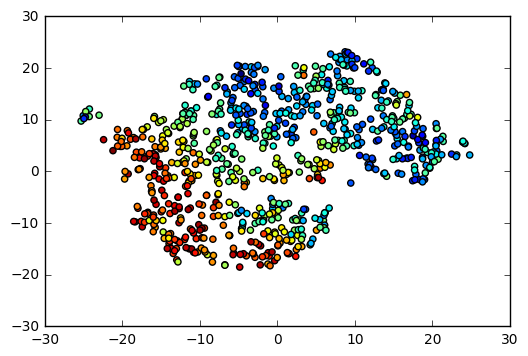

In [307]:
# from sklearn.manifold import TSNE
# blood_df.head
# from matplotlib import cm
temp_measurements = pd.concat([blood_df, measurements_df] ,axis=1)
temp_measurements = measurements_df
temp_measurements = temp_measurements.fillna(temp_measurements.median())
# temp_measurements = measurements_df[['BMI', 'BPdia', 'BPsys', 'BodyWeight', 'HeartRate', 'Height', 'Hips', 'WHR', 'Waist', 'Age']].fillna(measurements_df.median())
print(temp_measurements.columns)
k = 10
print (temp_measurements.columns[k])
temp_measurements = temp_measurements.values
temp_measurements.shape
# model = TSNE(n_components=2, random_state=0)
# m = model.fit_transform(temp_measurements) 

plt.scatter(m[:,0], m[:,1], c = temp_measurements[:,k])
plt.show()

In [6]:
X = xy_raw_df.drop('label', axis=1)
Y = np.asarray(xy_raw_df['label'].tolist())

In [7]:
# useful variables:
# list of connection IDs
cids = glucose_df.index.get_level_values('ConnectionID').unique().tolist()

In [24]:
# MEALS_LABELS = ['Weight', 'Protein_g', 'TotalLipid_g', 'Carbohydrate_g', 'Water_g', 'Alcohol_g', 'Energy_kcal']
# DATA_RESOLUTION_MIN = 5
# meals_df = pd.read_pickle(os.path.join(data_dir, 'Meals.df'))


# meals_df = meals_df.reset_index('MealEventID', drop=True)\
#     .set_index('Timestamp', append=True).sort_index()
# meals_df = meals_df[MEALS_LABELS].fillna(0)
# meals_df = meals_df.reset_index(level='Timestamp', drop=False)
# meals_df['Timestamp'] = pd.DatetimeIndex(meals_df['Timestamp']).round(str(DATA_RESOLUTION_MIN) + 'min')
# meals_df.set_index('Timestamp', inplace=True, append=True)
# meals_df = meals_df.fillna(0)
# meals_df = meals_df.groupby(level=['ConnectionID', 'Timestamp']).apply(np.sum)
# # meals_df = self.dfs['glucose'].join(meals_df)
# # meals_df = meals_df.drop('GlucoseValue', 1).fillna(0)

# testfood_df = testfoods_df.reset_index(level='EventID', drop=True).set_index('Timestamp', append=True).sort_index()
# testfood_df = testfood_df[MEALS_LABELS].fillna(0)
# testfood_df = testfood_df.reset_index(level='Timestamp', drop=False)
# testfood_df['Timestamp'] = pd.DatetimeIndex(testfood_df['Timestamp']).round(str(DATA_RESOLUTION_MIN) + 'min')
# testfood_df.set_index('Timestamp', inplace=True, append=True)
# testfood_df = testfood_df.fillna(0)
# testfood_df = testfood_df.groupby(level=['ConnectionID', 'Timestamp']).apply(np.sum)

# meals_df = meals_df.reset_index(level='Timestamp', drop=False)
# testfood_df = testfood_df.reset_index(level='Timestamp', drop=False)
# meals_df = pd.concat([meals_df, testfood_df], axis=0)
# meals_df.set_index('Timestamp', inplace=True, append=True)
# meals_df = meals_df.sort_index()
# meals_df = meals_df.groupby(level=['ConnectionID', 'Timestamp']).apply(np.sum)

# merged_df = ground.join(meals_df)
# merged_df = merged_df.fillna(0)
# merged_df.head
merged_df.columns

Index(['GlucoseValue', 'Weight', 'Protein_g', 'TotalLipid_g', 'Carbohydrate_g',
       'Water_g', 'Alcohol_g', 'Energy_kcal'],
      dtype='object')

# Glucose levels on a timeline

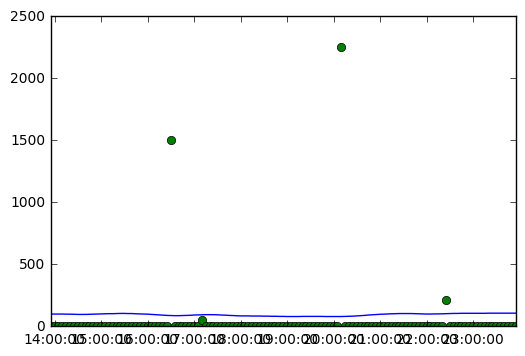

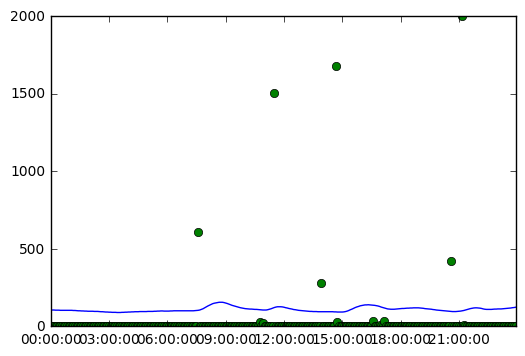

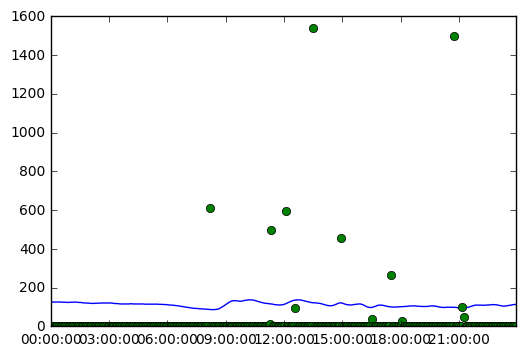

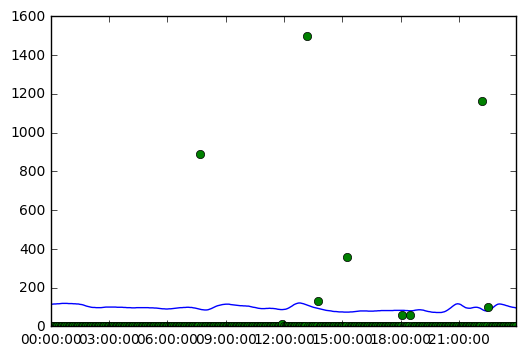

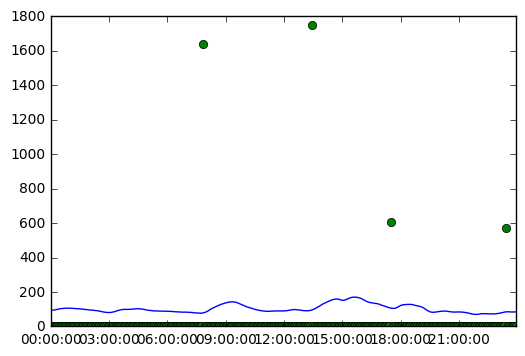

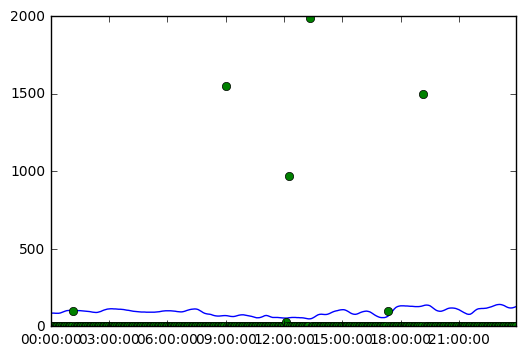

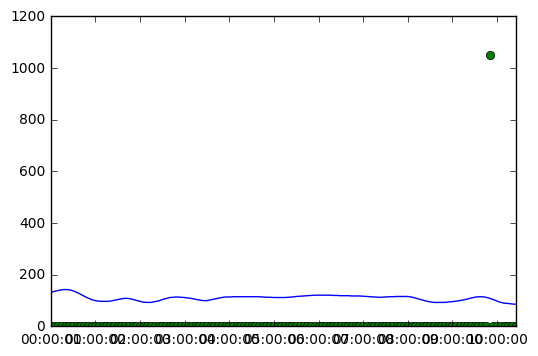

In [27]:
# select a random person and its glucose values
import random

rid = random.choice(cids)
user_glvals = glucose_df.loc[rid, :]
user_vals = merged_df.loc[rid, :]
# group glucose levels by days
glc_by_days = user_glvals.groupby(pd.Grouper(level='Timestamp', freq='D'))
vals_by_days = user_vals.groupby(pd.Grouper(level='Timestamp', freq='D'))
# plot glucose level for each day:

for key, grp in vals_by_days:
    plt.figure()
    plt.plot(grp.index, grp['GlucoseValue'])
    plt.plot(grp.index, grp['Weight'], 'o')
    plt.show()
#     grp.plot(title="glucose values of ID " + str(rid) + " at " + str(key.date()))


#  Histograms
## Differences in glucose levels (1h)

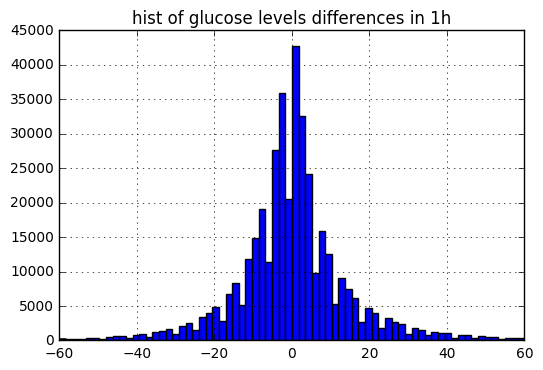

In [5]:
# By using the xy matrix:
xy_df.hist(bins=70, range=[-60,60])
plt.title("hist of glucose levels differences in 1h")
plt.show()

## Blood tests

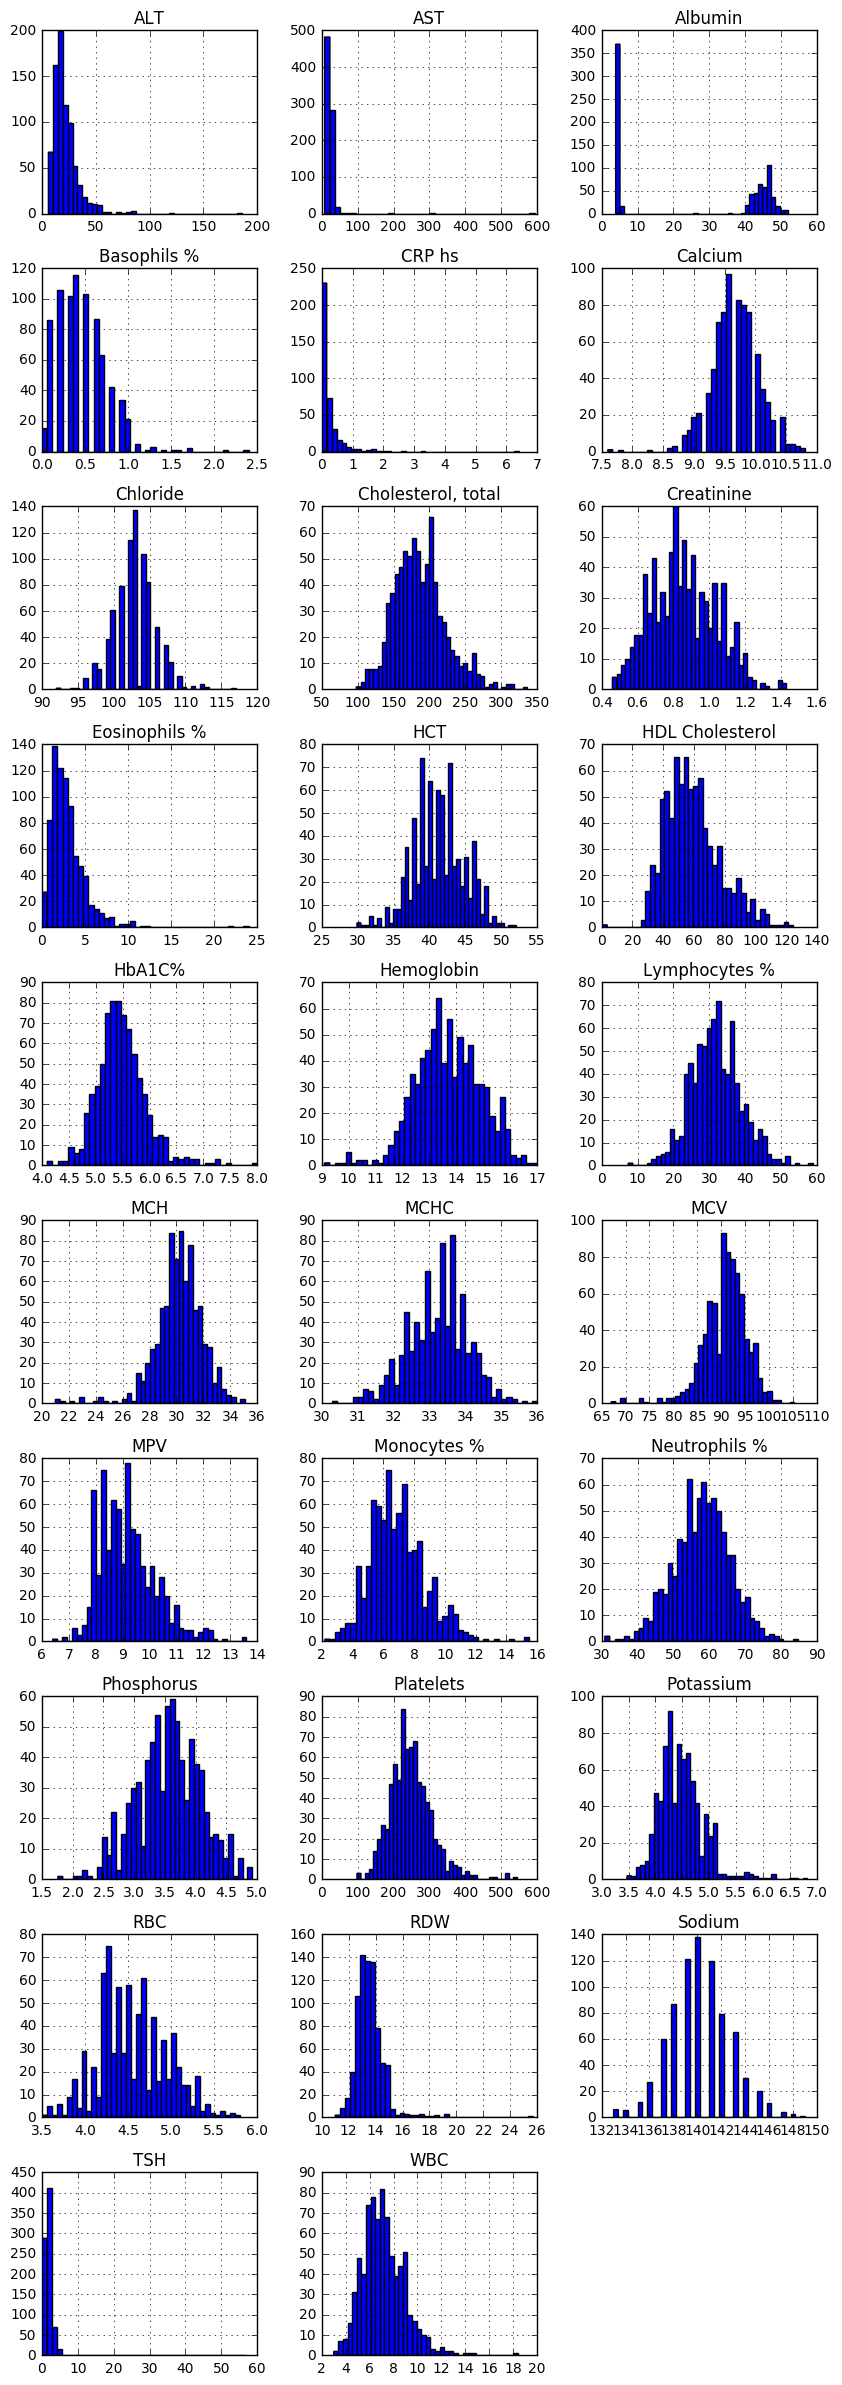

In [6]:
# #all parameters 
# blood_params = blood_df.columns.values.tolist()

blood_df.drop(["CRP (WIDE RANGE)"], axis=1).hist(bins=40, layout=(10, 3), figsize=(10,30))
# plt.rc('font', size=12)          # controls default text sizes
plt.show()

## Measurments

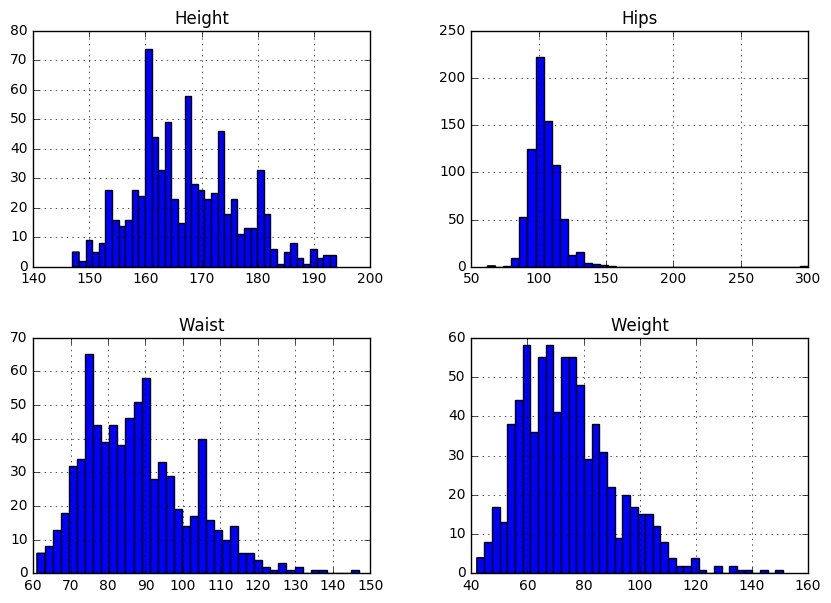

In [12]:
measurements_df.hist(bins=40, figsize=(10, 7))
plt.show()

## Bacteria species

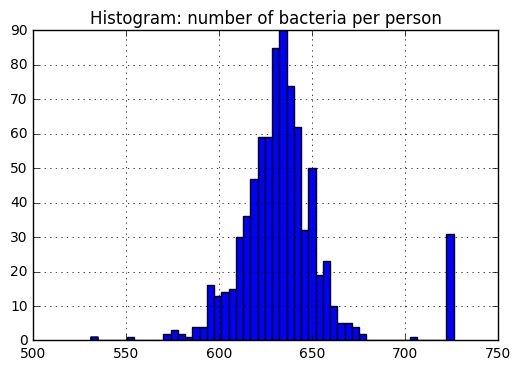

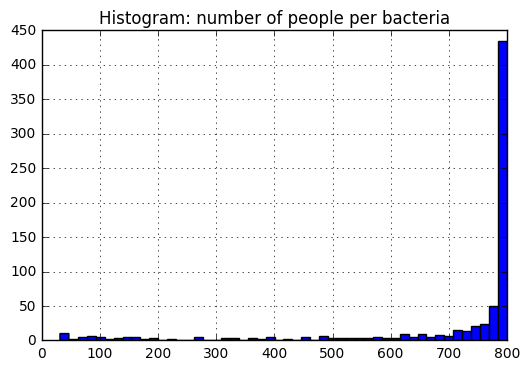

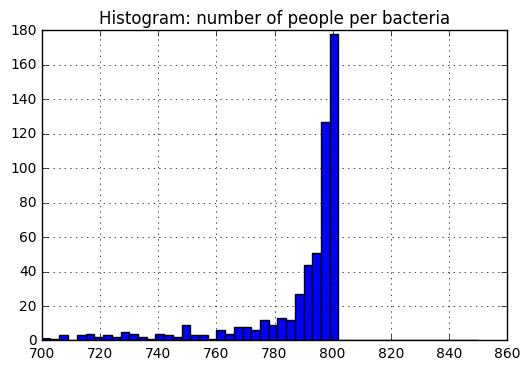

In [26]:
# count for each row (user) how much not NaN values it has:
bacteria_df.apply(lambda x: x.isnull().sum(), axis=1).hist(bins=50)
plt.title("Histogram: number of bacteria per person")
plt.show()

# count for each bacteria, for how many users it is not null:
bacteria_df.apply(lambda x: x.isnull().sum(), axis=0).hist(bins=50)
plt.title("Histogram: number of people per bacteria")
plt.show()

# refined histogram:
bacteria_df.apply(lambda x: x.isnull().sum(), axis=0).hist(bins=50, range=(700,850))
plt.title("Histogram: number of people per bacteria")
plt.show()